### СОРЕВНОВАНИЕ!

Задача нам уже знакома - нужно предсказать, сможет ли пользователь успешно закончить онлайн курс Анализ данных в R.

Мы будем считать, что пользователь успешно закончил курс, если он правильно решил больше 40 практических заданий.

В данных:

- submission_data_test.csv
- events_data_test.csv

хранится информация о решениях и действиях для 6184 студентов **за первые два дня** прохождения курса. Это 6184 студентов, которые проходили курс в период с мая 2018 по январь 2019. 

Используя данные о первых двух днях активности на курсе вам нужно предсказать,
 
        наберет ли пользователь более 40 баллов на курсе или нет.

В этих данных, вам доступны только первые дня активности студентов для того, чтобы сделать предсказание. На самом деле, используя эти данные, вы уже можете сделать прогноз. Например, если пользователь за первые два дня набрал 40 баллов, скорее всего он наберет более 40 баллов в дальнейшем. Чтобы подкрепить такие гипотезы, вы можете использовать данные, на которые мы исследовали в первых двух модулях курса, где для всех пользователей представлены все данные об их активности на курсе. 

In [185]:
from sklearn import tree
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from IPython.display import SVG
from graphviz import Source
from IPython.display import display
import numpy as np

from IPython.display import HTML
style = "<style>svg{width:30% !important;height:30% !important;}</style>"
HTML(style)

from sklearn.model_selection import train_test_split

from sklearn.model_selection import cross_val_score, GridSearchCV

from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

        Блок для построения таблицы корреляции фичей

k = len(X.columns)      # число строк и столбцов таблицы корреляции

cols = X.corr().nlargest(k, 'volume')['volume'].index

cm = X[cols].corr()

plt.figure(figsize = (10,6))

sns.heatmap(cm, annot= True, cmap= 'viridis')

        Блок для построения таблицы важности фичей

feature_importances_df = pd.DataFrame({'features':list(X.columns), 
                                       'feature_importances':  best_clf.feature_importances_})\
                        .sort_values(by='feature_importances', ascending= False)

feature_importances_df

In [186]:
events = pd.read_csv('events_data_test.csv')
events

,step_id,timestamp,action,user_id
0,30456,1526893787,viewed,24417
1,30456,1526893797,viewed,24417
2,30456,1526893954,viewed,24417
3,30456,1526895780,viewed,24417
4,30456,1526893787,discovered,24417
...,...,...,...,...
274763,158433,1545846175,discovered,3649
274764,158433,1545846175,passed,3649
274765,158433,1545846283,viewed,20953
274766,158433,1545846283,discovered,20953


Узнаем сколько уникальных пользователей - их 6184

In [187]:
events.user_id.nunique()

6184

проверяем количество уникальных дней, проведенных пользователями на платформе (по условию задачи выборку сделали для первых двух дней)

In [188]:
events['date'] = pd.to_datetime(events.timestamp, unit = 's')
events['days'] = events.date.dt.date
events

,step_id,timestamp,action,user_id,date,days
0,30456,1526893787,viewed,24417,2018-05-21 09:09:47,2018-05-21
1,30456,1526893797,viewed,24417,2018-05-21 09:09:57,2018-05-21
2,30456,1526893954,viewed,24417,2018-05-21 09:12:34,2018-05-21
3,30456,1526895780,viewed,24417,2018-05-21 09:43:00,2018-05-21
4,30456,1526893787,discovered,24417,2018-05-21 09:09:47,2018-05-21
...,...,...,...,...,...,...
274763,158433,1545846175,discovered,3649,2018-12-26 17:42:55,2018-12-26
274764,158433,1545846175,passed,3649,2018-12-26 17:42:55,2018-12-26
274765,158433,1545846283,viewed,20953,2018-12-26 17:44:43,2018-12-26
274766,158433,1545846283,discovered,20953,2018-12-26 17:44:43,2018-12-26


In [189]:
events.groupby('user_id').agg({'days':'nunique'}).value_counts()

days
1       4789
2        914
3        481
dtype: int64

In [190]:
sub_df = pd.read_csv('/Users/tony_builder/Documents/GitHub/studying/ML_stepic_carpov/submission_data_test.csv')
sub_df

,step_id,timestamp,submission_status,user_id
0,31971,1526800961,wrong,24370
1,31971,1526800976,wrong,24370
2,31971,1526800993,wrong,24370
3,31971,1526801054,correct,24370
4,31972,1526800664,wrong,24370
...,...,...,...,...
42256,120745,1539247150,correct,448
42257,120745,1540380070,wrong,9418
42258,120745,1543165802,correct,8093
42259,120745,1544465625,wrong,25737


В это же время уникальных пользователей в таблице верных/неверных решений всего 2803 - это говорит о том, что есть огромное число пользователей, которые не пробовали решать ни одной задачи в первые два дня 

In [191]:
sub_df.user_id.nunique()

2803

        Result example : пользователь - вероятность набрать более 40 баллов на курсе 
(по данным нахождения на курсе 2 дня)

In [192]:
res_ex = pd.read_csv('submission_example.csv')
res_ex

,user_id,is_gone
0,12,0.26
1,13,0.79
2,15,0.12
3,21,0.67
4,35,0.62
...,...,...
6179,7315,0.72
6180,24300,0.35
6181,820,0.88
6182,3649,0.38


в обеих табличках выборок наблюдается и трое суток, задетых отсчетом 2 дней (начало поздним вечером первого дня, весь следующий день, утро/день через сутки - вот и получается три)

In [193]:
sub_df['date'] = pd.to_datetime(sub_df.timestamp, unit = 's')   # добавим столбец перевода врем метки в дату
sub_df['days'] = sub_df.date.dt.date                            # уберем в столбце даты точное время    

sub_df.groupby('user_id').agg({'days':'nunique'}).value_counts()

days
1       1930
2        633
3        240
dtype: int64

Теперь переработаем данные обеих табличек в удобный вид для модели предсказания:

1) уберем лишние колонки
2) перевернем таблички, показывая количество действий каждого пользователя 
- для events - все виды его действий
- для submission - все его попытки положительных и отрицательных решений

In [194]:
events = events.drop(['timestamp', 'date' ], axis = 1)

In [195]:
sub_df = sub_df.drop(['timestamp', 'date' ], axis = 1)

In [196]:
events_actions = events.pivot_table(index='user_id', 
                        columns='action',                   # здесь назначили имена колонок
                        values='step_id',                   # здесь сообщили откуда взять значения для заполнения
                        aggfunc='count',                    # здесь сказали что делать с этими значениями
                        fill_value=0)                       # здесь сказали, что делать с отсутствующими значениями
                        
events_actions.reset_index()

action,user_id,discovered,passed,started_attempt,viewed
0,4,1,1,0,1
1,6,1,1,0,1
2,10,2,2,0,6
3,12,11,9,4,14
4,13,70,70,35,105
...,...,...,...,...,...
6179,26791,1,1,0,1
6180,26795,1,1,0,1
6181,26796,6,4,2,12
6182,26799,6,6,2,6


In [197]:
submissions_moves = sub_df.pivot_table(index='user_id', 
                        columns='submission_status',                   # здесь назначили имена колонок
                        values='step_id',                   # здесь сообщили откуда взять значения для заполнения
                        aggfunc='count',                    # здесь сказали что делать с этими значениями
                        fill_value=0)                       # здесь сказали, что делать с отсутствующими значениями
                        
submissions_moves.reset_index()

submission_status,user_id,correct,wrong
0,12,1,0
1,13,29,36
2,15,10,30
3,21,24,103
4,35,7,35
...,...,...,...
2798,26775,46,160
2799,26780,16,7
2800,26785,3,1
2801,26796,2,3


        Теперь еще раз в чем соль: 
        - в предыдущих уроках мы поработали с данными ДО 19 мая 2018 года включительно
        - здесь нам даются данные после 20 мая 2018 года (для каждого юзера он уникален, вплоть до 20 января 2019) + 2 дня

Тогда стратегия видится мне такой:
1) взять данные о пользователях, которые проходили курс до 19 мая 2018 года, предобработать их
2) завести переменную типа "Набрал более 40 баллов"
3) взять всю активность пользователя за два дня 
4) и сопоставить - кто в итоге из них наберет 40 баллов, а кто нет (глядя только на активность первых двух дней)
5) на основании такой таблицы обучить модель, узнать ее точность (сделать train и test datasets)
6) такой моделью предсказать какие из пользователей наберут более 40 баллов в НОВЫХ таблицах (то есть пользователи после 20 мая 2018 года)

Так, а что такое "Вероятность набрать более 40 баллов"?
- это отношение числа пользователей, кто не набрал 40 баллов за первые два дня присутствия на сайте, но обязательно наберет
- к числу всех пользователей

Итак, считаем данные для пользователей до 20.05.18 и преобработаем

In [198]:
events_data= pd.read_csv('/Users/tony_builder/tony. Личное/IT/Mashine Learning/event_data_train.csv')
events_data['date'] = pd.to_datetime(events_data.timestamp, unit = 's')
events_data['day'] = events_data.date.dt.date

events_uniq = events_data.pivot_table(index='user_id', 
                        columns='action',                   # здесь назначили имена колонок
                        values='step_id',                   # здесь сообщили откуда взять значения для заполнения
                        aggfunc='count',                    # здесь сказали что делать с этими значениями
                        fill_value=0)\
                        .reset_index()

events_uniq

action,user_id,discovered,passed,started_attempt,viewed
0,1,1,0,0,1
1,2,9,9,2,10
2,3,91,87,30,192
3,5,11,11,4,12
4,7,1,1,0,1
...,...,...,...,...,...
19229,26790,8,8,1,9
19230,26793,1,0,1,1
19231,26794,69,69,34,180
19232,26797,10,10,2,13


In [199]:
submissions_data = pd.read_csv('/Users/tony_builder/tony. Личное/IT/Mashine Learning/submissions_data_train.csv')
submissions_data['date'] = pd.to_datetime(submissions_data.timestamp, unit = 's')
submissions_data['day'] = submissions_data.date.dt.date

users_scores = submissions_data.pivot_table(index='user_id', 
                        columns='submission_status', 
                        values='step_id', 
                        aggfunc='count', 
                        fill_value=0).reset_index()
users_scores

submission_status,user_id,correct,wrong
0,2,2,0
1,3,29,23
2,5,2,2
3,8,9,21
4,14,0,1
...,...,...,...
9935,26787,3,0
9936,26790,1,0
9937,26794,33,9
9938,26797,2,0


Сошьем общую таблицу пользователей, где будет вся имеющаяся у нас информация о том, что он делал на степах.

Пустые значения заполним нулями

In [200]:
users_before_20052018 = events_uniq.merge(users_scores, how='outer')
users_before_20052018= users_before_20052018.fillna(0)

users_before_20052018

,user_id,discovered,passed,started_attempt,viewed,correct,wrong
0,1,1,0,0,1,0.0,0.0
1,2,9,9,2,10,2.0,0.0
2,3,91,87,30,192,29.0,23.0
3,5,11,11,4,12,2.0,2.0
4,7,1,1,0,1,0.0,0.0
...,...,...,...,...,...,...,...
19229,26790,8,8,1,9,1.0,0.0
19230,26793,1,0,1,1,0.0,0.0
19231,26794,69,69,34,180,33.0,9.0
19232,26797,10,10,2,13,2.0,0.0


Заведем новый столбец с целевой переменной (набрал больше 40 баллов или нет)

In [201]:
users_before_20052018.sort_values('correct')

,user_id,discovered,passed,started_attempt,viewed,correct,wrong
0,1,1,0,0,1,0.0,0.0
10656,14794,43,33,0,55,0.0,0.0
10657,14795,2,2,0,2,0.0,0.0
10658,14796,1,1,0,1,0.0,0.0
10659,14797,1,1,0,1,0.0,0.0
...,...,...,...,...,...,...,...
6113,8461,198,198,154,977,135.0,42.0
4479,6183,196,196,150,758,142.0,65.0
12338,17135,196,196,190,1040,168.0,177.0
4007,5552,198,198,224,1141,186.0,93.0


Можно завести еще колонку, чтобы увидеть, сколько попыток совершал пользователь при решении

смысл:
- увидеть, как влияло то, что он много раз ошибался, на его стремление идти дальше
- показать модели эту зависимость

In [202]:
users_before_20052018['atempt_decision'] = users_before_20052018.correct / (users_before_20052018.wrong \
                                                                            + users_before_20052018.correct)

users_before_20052018 = users_before_20052018.fillna(0)

users_before_20052018.atempt_decision = users_before_20052018.atempt_decision.round(2)      # округлим до 2 знака после запятой

users_before_20052018

,user_id,discovered,passed,started_attempt,viewed,correct,wrong,atempt_decision
0,1,1,0,0,1,0.0,0.0,0.00
1,2,9,9,2,10,2.0,0.0,1.00
2,3,91,87,30,192,29.0,23.0,0.56
3,5,11,11,4,12,2.0,2.0,0.50
4,7,1,1,0,1,0.0,0.0,0.00
...,...,...,...,...,...,...,...,...
19229,26790,8,8,1,9,1.0,0.0,1.00
19230,26793,1,0,1,1,0.0,0.0,0.00
19231,26794,69,69,34,180,33.0,9.0,0.79
19232,26797,10,10,2,13,2.0,0.0,1.00


In [203]:
users_before_20052018['scores_more_40_points'] = (users_before_20052018.correct > 40).map(int)
# булево значение заменим на 1/0

users_before_20052018

,user_id,discovered,passed,started_attempt,viewed,correct,wrong,atempt_decision,scores_more_40_points
0,1,1,0,0,1,0.0,0.0,0.00,0
1,2,9,9,2,10,2.0,0.0,1.00,0
2,3,91,87,30,192,29.0,23.0,0.56,0
3,5,11,11,4,12,2.0,2.0,0.50,0
4,7,1,1,0,1,0.0,0.0,0.00,0
...,...,...,...,...,...,...,...,...,...
19229,26790,8,8,1,9,1.0,0.0,1.00,0
19230,26793,1,0,1,1,0.0,0.0,0.00,0
19231,26794,69,69,34,180,33.0,9.0,0.79,0
19232,26797,10,10,2,13,2.0,0.0,1.00,0


Убедимся, что есть и нолики, и единички

In [204]:
users_before_20052018.scores_more_40_points.value_counts()

0    17266
1     1968
Name: scores_more_40_points, dtype: int64

Разделим наши переменные на целевую и на фичи

разобьем их на тренировочный и тестовый датасэты (для проверки точности модели)

но перед этим посмотрим на корреляцию фичей

In [205]:
users_before_20052018 = users_before_20052018.set_index(users_before_20052018.user_id).drop(['user_id'], axis =1)

users_before_20052018

,discovered,passed,started_attempt,viewed,correct,wrong,atempt_decision,scores_more_40_points
user_id,,,,,,,,
1,1,0,0,1,0.0,0.0,0.00,0
2,9,9,2,10,2.0,0.0,1.00,0
3,91,87,30,192,29.0,23.0,0.56,0
5,11,11,4,12,2.0,2.0,0.50,0
7,1,1,0,1,0.0,0.0,0.00,0
...,...,...,...,...,...,...,...,...
26790,8,8,1,9,1.0,0.0,1.00,0
26793,1,0,1,1,0.0,0.0,0.00,0
26794,69,69,34,180,33.0,9.0,0.79,0


In [206]:
X= users_before_20052018.drop('scores_more_40_points', axis=1)
y = users_before_20052018.scores_more_40_points

<AxesSubplot: >

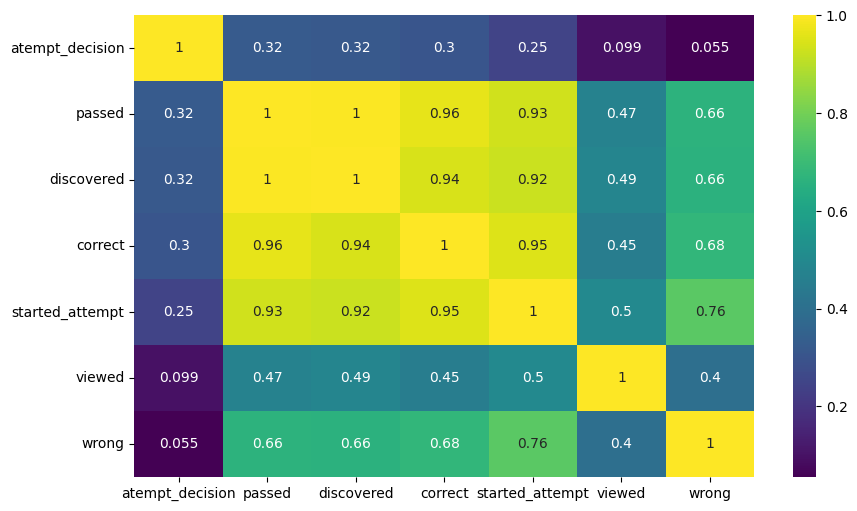

In [207]:
k = len(X.columns)      # число строк и столбцов таблицы корреляции

cols = X.corr().nlargest(k, 'atempt_decision')['atempt_decision'].index

cm = X[cols].corr()

plt.figure(figsize = (10,6))

sns.heatmap(cm, annot= True, cmap= 'viridis')

In [208]:
X_train, X_test, y_train, y_test =  train_test_split(X, y, test_size=0.3, random_state=42)

In [209]:
clf = RandomForestClassifier(random_state=42)

parametrs = {'n_estimators': range(10,120,20), 'max_depth': range(2,8), 
             'min_samples_leaf': range(1,12,5), 
             'criterion':['gini', 'entropy'] , 
             'min_samples_split': range(2,10,4)}

# grid_search_cv_clf = GridSearchCV(clf, parametrs, cv=5)

# grid_search_cv_clf.fit(X_train, y_train)

In [210]:
# grid_search_cv_clf.best_params_

best_params_:
{'criterion': 'gini',
 'max_depth': 2,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 70}

In [211]:
# best_clf = grid_search_cv_clf.best_estimator_

In [212]:
best_clf = RandomForestClassifier(criterion='gini', max_depth=2, min_samples_leaf=1, min_samples_split=2, n_estimators=70)

best_clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=2, n_estimators=70)

In [213]:
clf = RandomForestClassifier(criterion='gini', max_depth=2, min_samples_leaf=1, min_samples_split=2, n_estimators=70)

clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=2, n_estimators=70)

In [214]:
y_predicted = clf.predict(X_test)

print(f'- Accuracy  (общая точность) модели равна {round(accuracy_score(y_test, y_predicted), 3)}')
print(f'- Precision(точность с учетом ложных срабатываний) модели равна {round(precision_score(y_test, y_predicted), 3)}')
print(f'- Recall    (полнота верных срабатываний) модели равна {round(recall_score(y_test, y_predicted), 3)}')
print(f'- f1_score  (соотношение тоночти и полноты) модели равна {round(f1_score(y_test, y_predicted), 3)}')

- Accuracy  (общая точность) модели равна 0.996
- Precision(точность с учетом ложных срабатываний) модели равна 0.971
- Recall    (полнота верных срабатываний) модели равна 0.988
- f1_score  (соотношение тоночти и полноты) модели равна 0.979


In [215]:
y_predicted = best_clf.predict(X_test)

print(f'- Accuracy  (общая точность) модели равна {round(accuracy_score(y_test, y_predicted), 3)}')
print(f'- Precision(точность с учетом ложных срабатываний) модели равна {round(precision_score(y_test, y_predicted), 3)}')
print(f'- Recall    (полнота верных срабатываний) модели равна {round(recall_score(y_test, y_predicted), 3)}')
print(f'- f1_score  (соотношение тоночти и полноты) модели равна {round(f1_score(y_test, y_predicted), 3)}')

- Accuracy  (общая точность) модели равна 0.997
- Precision(точность с учетом ложных срабатываний) модели равна 0.975
- Recall    (полнота верных срабатываний) модели равна 1.0
- f1_score  (соотношение тоночти и полноты) модели равна 0.987


In [217]:
y_pred_probability = best_clf.predict_proba(X_test) 

In [219]:
prob_scores_40_df = pd.DataFrame(y_pred_probability).rename(columns = {0: 'wont_score', 1: 'will_score'})

prob_scores_40_df

,wont_score,will_score
0,0.906424,0.093576
1,0.999545,0.000455
2,0.993625,0.006375
3,0.999545,0.000455
4,0.999545,0.000455
...,...,...
5766,0.999545,0.000455
5767,0.999545,0.000455
5768,0.028013,0.971987
5769,0.999545,0.000455


<AxesSubplot: >

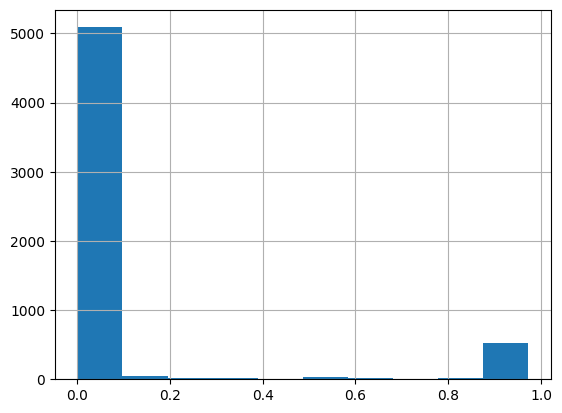

In [220]:
pd.Series(y_pred_probability[:, 1]).hist()

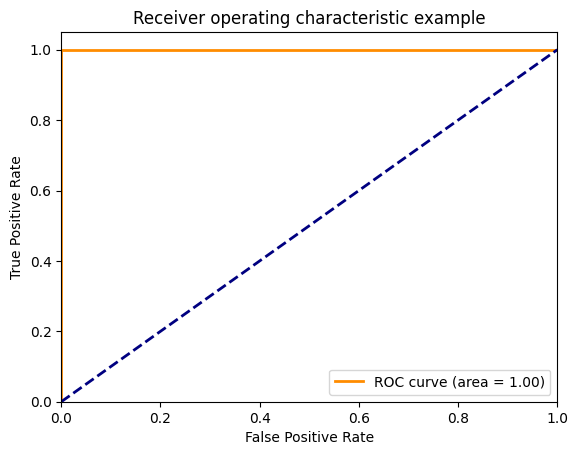

In [221]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probability[:,1])
roc_auc= auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange',
         lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()